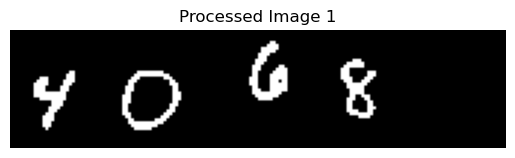

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def convert(img):
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    inverted_img = cv2.bitwise_not(binary_img)
    return binary_img
    

data_path = "data0.npy" 
images = np.load(data_path)

img = images[1]
inv_img=convert(img)

plt.imshow(inv_img, cmap="gray")
plt.title("Processed Image 1")
plt.axis("off")
plt.show()


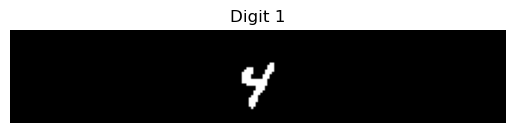

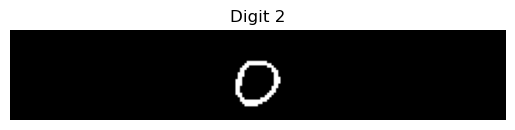

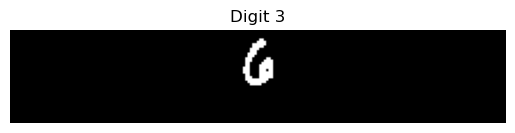

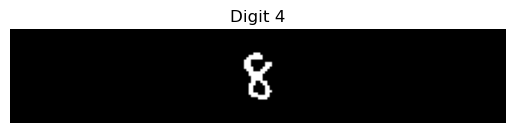

In [35]:
white_columns = np.all(inv_img == 0, axis=0)
split_points = np.where(white_columns)[0]
segments = []
start = 0

for end in split_points:
    if end > start + 1: 
        segments.append((start, end))
    start = end + 1

if start < inv_img.shape[1]:
    segments.append((start, inv_img.shape[1]))

for i, (start, end) in enumerate(segments):
    digit_img = inv_img[:, start:end]
    
    if digit_img.shape[1] < 2:
        continue
    padding = 100
    digit_img_padded = np.pad(digit_img, ((0, 0), (padding, padding)), mode='constant', constant_values=0)
    
    plt.imshow(digit_img_padded, cmap="gray")
    plt.title(f"Digit {i+1}")
    plt.axis("off")
    plt.show()

In [40]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)  
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  
        x = self.pool(torch.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 7 * 7)  
        x = torch.relu(self.fc1(x))  
        x = self.fc2(x) 
        return x

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


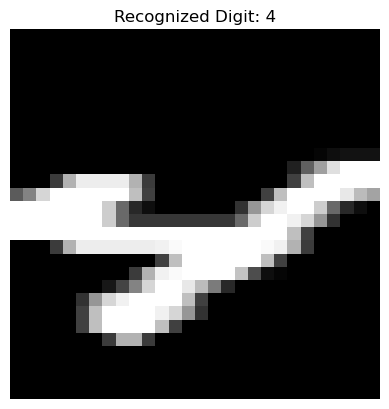

Digit 1: 4


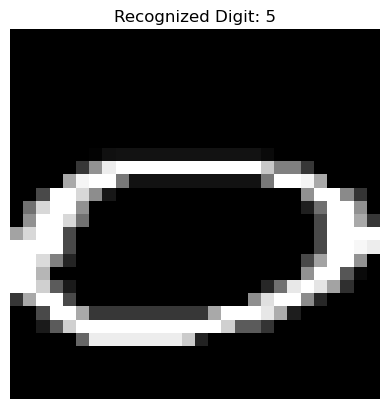

Digit 2: 5


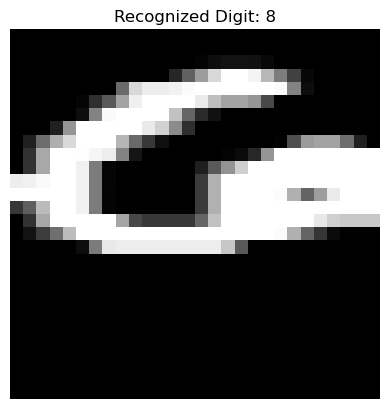

Digit 3: 8


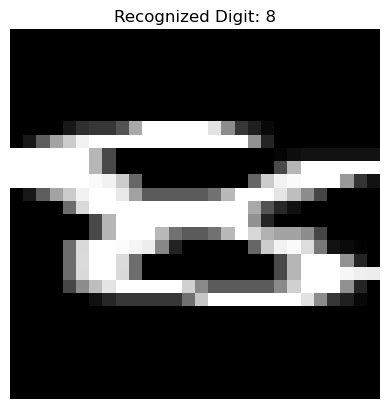

Digit 4: 8


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

sharpening_kernel = np.array([[0, -1, 0],
                               [-1, 5,-1],
                               [0, -1, 0]])

white_columns = np.all(inv_img == 0, axis=0)

split_points = np.where(white_columns)[0]

segments = []
start = 0

for end in split_points:
    if end > start + 1:  
        segments.append((start, end))
    start = end + 1

if start < inv_img.shape[1]:
    segments.append((start, inv_img.shape[1]))

model = CNN()  
model.load_state_dict(torch.load('mnist_cnn_model.pth'))
model.eval()  

for i, (start, end) in enumerate(segments):
    digit_img = inv_img[:, start:end]
    
    if digit_img.shape[1] < 2:
        continue
    
    digit_img_resized = cv2.resize(digit_img, (28, 28), interpolation=cv2.INTER_LINEAR)
    digit_img_resized = digit_img_resized.astype(np.float32) / 255.0
    digit_img_resized = digit_img_resized.reshape(1, 1, 28, 28)
    digit_img_tensor = torch.tensor(digit_img_resized)

    with torch.no_grad():  
        output = model(digit_img_tensor)
        _, predicted_digit = torch.max(output, 1)
    
    plt.imshow(digit_img_resized[0, 0], cmap="gray")
    plt.title(f"Recognized Digit: {predicted_digit.item()}")
    plt.axis("off")
    plt.show()

    print(f"Digit {i+1}: {predicted_digit.item()}")


Accuracy: 5.92%
Average Loss (MSE): 44.1455
Percentage within +-0.5: 5.92%
Percentage within +-1: 17.380000000000003%
Percentage within +-2: 29.39%


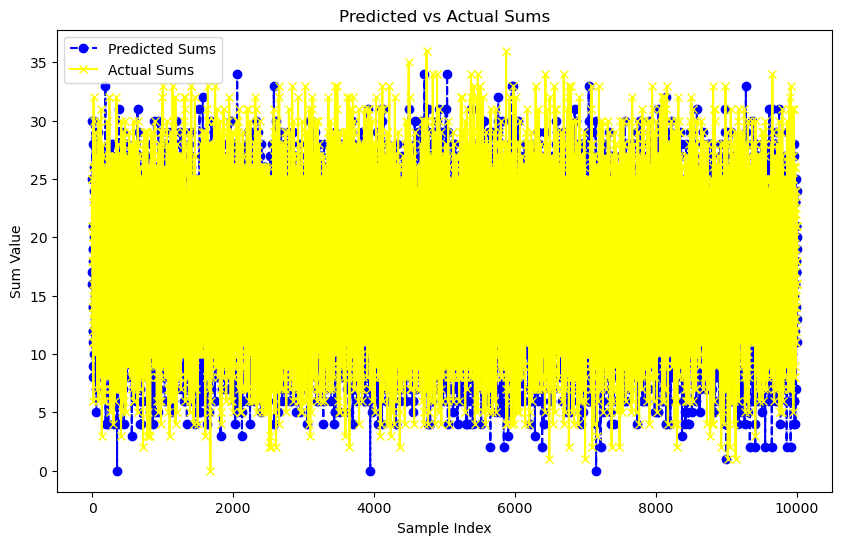

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error

images = np.load("data0.npy")
labels = np.load("lab0.npy")

c = 0
t = 0
loss = 0
sums = []
actual_sums = []

w_05 = 0
w_1 = 0
w_2 = 0

model = CNN()  
model.load_state_dict(torch.load('mnist_cnn_model.pth'))
model.eval()

for img, lab in zip(images, labels):
    start_time = time.time()  
    black_img = convert(img)  
    black_columns = np.all(black_img == 0, axis=0)
    split_points = np.where(black_columns)[0]

    segments = []
    start = 0
    for end in split_points:
        if end > start + 1:
            segments.append((start, end))
        start = end + 1
    if start < black_img.shape[1]:
        segments.append((start, black_img.shape[1]))

    s = 0

    for start, end in segments:
        digit_img = black_img[:, start:end]
        
        if digit_img.shape[1] < 2:
            continue
        
        digit_img_resized = cv2.resize(digit_img, (28, 28), interpolation=cv2.INTER_LINEAR)
        digit_img_resized = digit_img_resized.astype(np.float32) / 255.0
        digit_img_resized = digit_img_resized.reshape(1, 1, 28, 28)
        
        digit_img_tensor = torch.tensor(digit_img_resized)

        with torch.no_grad():
            output = model(digit_img_tensor)
            _, predicted_digit = torch.max(output, 1)
            s += predicted_digit.item()
    
    if s == lab:
        c += 1
    
    t += 1
    loss += mean_squared_error([lab], [s])
    sums.append(s)    
    if abs(s - lab) <= 0.5:
        w_05 += 1
    if abs(s - lab) <= 1:
        w_1 += 1
    if abs(s - lab) <= 2:
        w_2 += 1

accuracy = (c / t) * 100
average_loss = loss / t

print(f"Accuracy: {accuracy:.2f}%")
print(f"Average Loss (MSE): {average_loss:.4f}")
print(f"Percentage within +-0.5: {(w_05 / total_predictions) * 100}%")
print(f"Percentage within +-1: {(w_1 / total_predictions) * 100}%")
print(f"Percentage within +-2: {(w_2 / total_predictions) * 100}%")

plt.figure(figsize=(10, 6))
plt.plot(sums, label="Predicted Sums", marker='o', linestyle='--', color='blue')
plt.plot(labels, label="Actual Sums", marker='x', linestyle='-', color='yellow')
plt.xlabel('Sample Index')
plt.ylabel('Sum Value')
plt.title('Predicted vs Actual Sums')
plt.legend()
plt.show()


Accuracy: 6.54%
Average Loss (MSE): 45.1019
Percentage within +-0.5: 6.54%
Percentage within +-1: 18.3%
Percentage within +-2: 30.049999999999997%


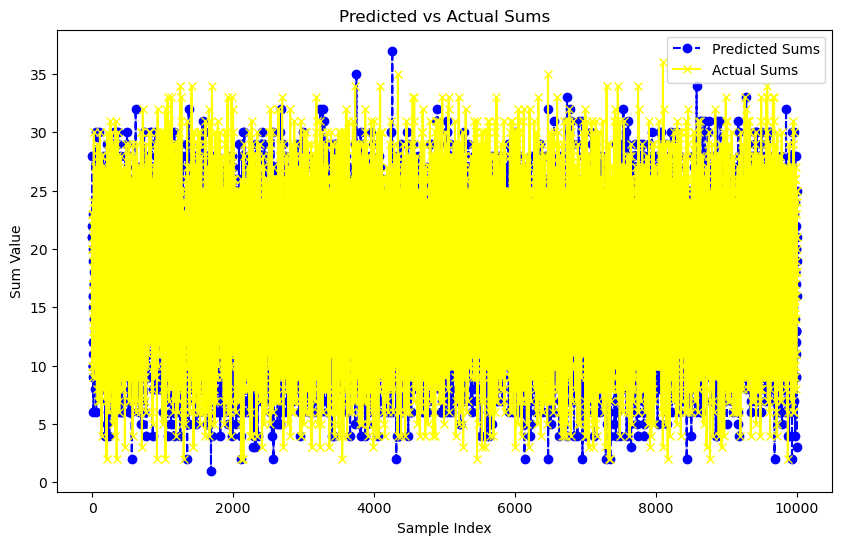

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error

images = np.load("data1.npy")
labels = np.load("lab1.npy")

c = 0
t = 0
loss = 0
sums = []
actual_sums = []

w_05 = 0
w_1 = 0
w_2 = 0

model = CNN()  
model.load_state_dict(torch.load('mnist_cnn_model.pth'))
model.eval()

for img, lab in zip(images, labels):
    start_time = time.time()  
    black_img = convert(img)  
    black_columns = np.all(black_img == 0, axis=0)
    split_points = np.where(black_columns)[0]

    segments = []
    start = 0
    for end in split_points:
        if end > start + 1:
            segments.append((start, end))
        start = end + 1
    if start < black_img.shape[1]:
        segments.append((start, black_img.shape[1]))

    s = 0

    for start, end in segments:
        digit_img = black_img[:, start:end]
        
        if digit_img.shape[1] < 2:
            continue
        
        digit_img_resized = cv2.resize(digit_img, (28, 28), interpolation=cv2.INTER_LINEAR)
        digit_img_resized = digit_img_resized.astype(np.float32) / 255.0
        digit_img_resized = digit_img_resized.reshape(1, 1, 28, 28)
        
        digit_img_tensor = torch.tensor(digit_img_resized)

        with torch.no_grad():
            output = model(digit_img_tensor)
            _, predicted_digit = torch.max(output, 1)
            s += predicted_digit.item()
    
    if s == lab:
        c += 1
    
    t += 1
    loss += mean_squared_error([lab], [s])
    sums.append(s)    
    if abs(s - lab) <= 0.5:
        w_05 += 1
    if abs(s - lab) <= 1:
        w_1 += 1
    if abs(s - lab) <= 2:
        w_2 += 1

accuracy = (c / t) * 100
average_loss = loss / t

print(f"Accuracy: {accuracy:.2f}%")
print(f"Average Loss (MSE): {average_loss:.4f}")
print(f"Percentage within +-0.5: {(w_05 / total_predictions) * 100}%")
print(f"Percentage within +-1: {(w_1 / total_predictions) * 100}%")
print(f"Percentage within +-2: {(w_2 / total_predictions) * 100}%")

plt.figure(figsize=(10, 6))
plt.plot(sums, label="Predicted Sums", marker='o', linestyle='--', color='blue')
plt.plot(labels, label="Actual Sums", marker='x', linestyle='-', color='yellow')
plt.xlabel('Sample Index')
plt.ylabel('Sum Value')
plt.title('Predicted vs Actual Sums')
plt.legend()
plt.show()


Accuracy: 6.59%
Average Loss (MSE): 44.0277
Percentage within +-0.5: 6.59%
Percentage within +-1: 18.23%
Percentage within +-2: 29.520000000000003%


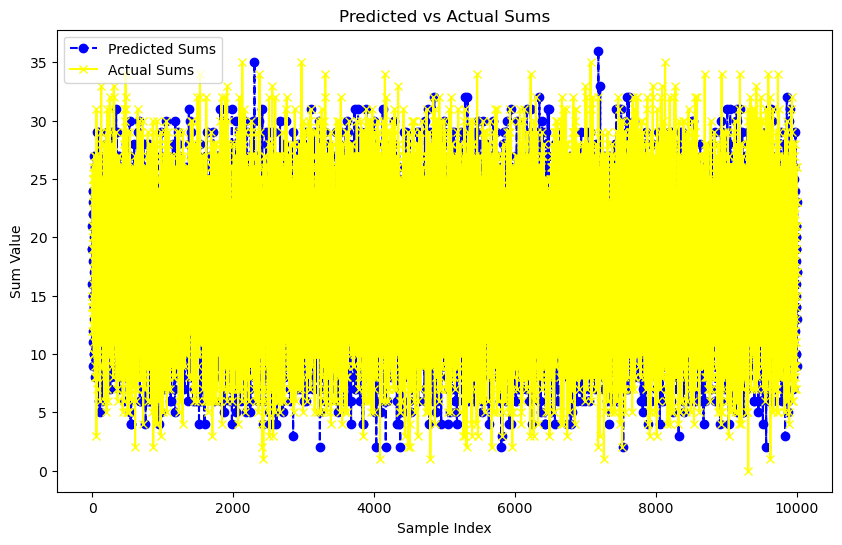

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error

images = np.load("data2.npy")
labels = np.load("lab2.npy")

c = 0
t = 0
loss = 0
sums = []
actual_sums = []

w_05 = 0
w_1 = 0
w_2 = 0

model = CNN()  
model.load_state_dict(torch.load('mnist_cnn_model.pth'))
model.eval()

for img, lab in zip(images, labels):
    start_time = time.time()  
    black_img = convert(img)  
    black_columns = np.all(black_img == 0, axis=0)
    split_points = np.where(black_columns)[0]

    segments = []
    start = 0
    for end in split_points:
        if end > start + 1:
            segments.append((start, end))
        start = end + 1
    if start < black_img.shape[1]:
        segments.append((start, black_img.shape[1]))

    s = 0

    for start, end in segments:
        digit_img = black_img[:, start:end]
        
        if digit_img.shape[1] < 2:
            continue
        
        digit_img_resized = cv2.resize(digit_img, (28, 28), interpolation=cv2.INTER_LINEAR)
        digit_img_resized = digit_img_resized.astype(np.float32) / 255.0
        digit_img_resized = digit_img_resized.reshape(1, 1, 28, 28)
        
        digit_img_tensor = torch.tensor(digit_img_resized)

        with torch.no_grad():
            output = model(digit_img_tensor)
            _, predicted_digit = torch.max(output, 1)
            s += predicted_digit.item()
    
    if s == lab:
        c += 1
    
    t += 1
    loss += mean_squared_error([lab], [s])
    sums.append(s)    
    if abs(s - lab) <= 0.5:
        w_05 += 1
    if abs(s - lab) <= 1:
        w_1 += 1
    if abs(s - lab) <= 2:
        w_2 += 1

accuracy = (c / t) * 100
average_loss = loss / t

print(f"Accuracy: {accuracy:.2f}%")
print(f"Average Loss (MSE): {average_loss:.4f}")
print(f"Percentage within +-0.5: {(w_05 / total_predictions) * 100}%")
print(f"Percentage within +-1: {(w_1 / total_predictions) * 100}%")
print(f"Percentage within +-2: {(w_2 / total_predictions) * 100}%")

plt.figure(figsize=(10, 6))
plt.plot(sums, label="Predicted Sums", marker='o', linestyle='--', color='blue')
plt.plot(labels, label="Actual Sums", marker='x', linestyle='-', color='yellow')
plt.xlabel('Sample Index')
plt.ylabel('Sum Value')
plt.title('Predicted vs Actual Sums')
plt.legend()
plt.show()
